In [1]:
from oddt.scoring.descriptors import universal_descriptor
from oddt.fingerprints import PLEC
from oddt.toolkits import rdk, ob

from statistical_tests import bootstrap_pearsonr, permutation_pearsonr

import json
import numpy as np
from joblib import delayed, Parallel
from functools import partial
from sklearn.ensemble import RandomForestRegressor

from scipy import sparse, stats

from oddt.fingerprints import sparse_to_csr_matrix, csr_matrix_to_sparse, fold, sparse_to_dense
from matplotlib import pyplot as plt
import json
import pandas as pd

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

PDBBIND_DIR = '/home/fergus/pdbbind/v2019'

In [2]:
with open('../data/pdbbind_training_set.txt') as f:
    train_pdbs = [l.strip() for l in f]
    
with open('../data/pdbbind_test_set.txt') as f:
    test_pdbs = [l.strip() for l in f]

In [3]:
@delayed
def build(pdb):
    protein = next(ob.readfile('pdb', f'{PDBBIND_DIR}/{pdb}/{pdb}_protein.pdb'))
    protein.protein = True
    # crystal
    ligand = next(ob.readfile('sdf', f'{PDBBIND_DIR}/{pdb}/{pdb}_ligand.sdf'))
    features_c = PLEC(ligand, protein, depth_ligand=1, depth_protein=5, size=65536, count_bits=True, sparse=True, ignore_hoh=True)
    # docked        
    ligand = next(ob.readfile('sdf', f'../pdbbind_docked_poses/{pdb}/{pdb}_ligand_docked.sdf'))
    features_d = PLEC(ligand, protein, depth_ligand=1, depth_protein=5, size=65536, count_bits=True, sparse=True, ignore_hoh=True)
    return (features_c, features_d)

In [114]:
plecs_xtal = {}

with Parallel(n_jobs=6, verbose=10) as parallel:
    plecs_xtal = parallel(build_plec(pdb) for pdb in pdbs)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    4.1s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   11.0s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   15.2s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   22.2s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:   31.7s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   33.2s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:   35.7s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:   40.3s
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:   46.7s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:   51.0s
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:   55.4s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed:  1.3min
[Parallel(

In [113]:

with open('pdbbind_training_set_docked_plec_sparse.json', 'w') as f:
    json.dump(plecs, f, cls=NumpyEncoder)

In [115]:
with open('pdbbind_training_set_crystal_plec_sparse.json', 'w') as f:
    json.dump(plecs_xtal, f, cls=NumpyEncoder)

In [121]:
y = []
x_docked = []
x_crystal = []
labels = []
for plec_docked, plec_crystal, pdb in zip(plecs, plecs_xtal, pdbs):
    y.append(1)
    x_docked.append(sparse_to_csr_matrix(plec_docked, size=65536))
    x_crystal.append(sparse_to_csr_matrix(plec_crystal, size=65536))
    labels.append(pdb)
    #x.append(sparse_to_dense(plec, size=65536).tolist())
x_crystal = sparse.vstack(x_crystal, format='csr')
x_docked = sparse.vstack(x_docked, format='csr')

In [125]:
1792298/1916168 * 100

93.53553550628129

In [126]:
1916168/len(pdbs)

510.7057569296375

Docked poses have approx 93% the number of 'on' bits as crystal poses. Average of 510 of ~65.5k bits so very sparse!

In [122]:
x_crystal

<3752x65536 sparse matrix of type '<class 'numpy.uint8'>'
	with 1916168 stored elements in Compressed Sparse Row format>

In [123]:
x_docked

<3752x65536 sparse matrix of type '<class 'numpy.uint8'>'
	with 1792298 stored elements in Compressed Sparse Row format>

In [73]:
from oddt.fingerprints import sparse_to_csr_matrix, csr_matrix_to_sparse, fold

In [8]:
with Parallel(n_jobs=6, verbose=10) as parallel:
    test_features = parallel(build(pdb) for pdb in test_pdbs)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    3.0s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    7.5s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   10.1s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   16.0s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   20.5s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:   26.3s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   44.0s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:   52.0s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed:  2.4min
[Parallel(

In [14]:
test_features_crystal = {}
test_features_docked = {}

for feature, pdb in zip(test_features, test_pdbs):
    test_features_crystal[pdb] = feature[0]
    test_features_docked[pdb] = feature[1]
    
with open('pdbbind_test_set_docked_plec_sparse.json', 'w') as f:
    json.dump(test_features_docked, f, cls=NumpyEncoder)
    
with open('pdbbind_test_set_crystal_plec_sparse.json', 'w') as f:
    json.dump(test_features_crystal, f, cls=NumpyEncoder)

In [3]:
with open('pdbbind_training_set_docked_plec_sparse.json') as f:
    train_features_docked = json.load(f)
    
with open('pdbbind_training_set_crystal_plec_sparse.json') as f:
    train_features_crystal = json.load(f)

In [4]:
with open('pdbbind_test_set_docked_plec_sparse.json') as f:
    test_features_docked = json.load(f)
    
with open('pdbbind_test_set_crystal_plec_sparse.json') as f:
    test_features_crystal = json.load(f)

In [5]:
from sklearn.decomposition import TruncatedSVD

X_train_sparse = sparse.vstack([sparse_to_csr_matrix(plec, size=65536) for plec in train_features_crystal], format='csr')
X_test_sparse = sparse.vstack([sparse_to_csr_matrix(test_features_crystal[pdb], size=65536) for pdb in test_features_crystal], format='csr')

svd = TruncatedSVD(n_components=200, random_state=42).fit(X_train_sparse)
X_train_svd = svd.transform(X_train_sparse)
X_test_svd = svd.transform(X_test_sparse)

0.7337512171702328


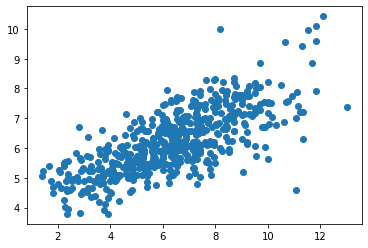

In [12]:
rf = RandomForestRegressor(n_estimators=500, max_features=0.33, random_state=42, n_jobs=8)
rf.fit(X_train_svd, train_affinity.values.ravel())
print(stats.pearsonr(test_affinity.values.ravel(), rf.predict(X_test_svd))[0])
plt.scatter(test_affinity.values.ravel(), rf.predict(X_test_svd))

In [23]:
train_affinity = pd.read_csv('../data/pdbbind_training_set_binding_affinity.csv', index_col=0, header=None, squeeze=True)
test_affinity = pd.read_csv('../data/pdbbind_test_set_binding_affinity.csv', index_col=0, header=None, squeeze=True)

In [8]:
y_train = []
X_train_crystal = []
X_train_docked = []
labels = []
for plec_docked, plec_crystal, pdb in zip(train_features_crystal, train_features_docked, train_pdbs):
    X_train_crystal.append(sparse_to_csr_matrix(plec_crystal, size=65536))
    X_train_docked.append(sparse_to_csr_matrix(plec_docked, size=65536))
    y_train.append(train_affinity.loc[pdb])
X_train_crystal = sparse.vstack(X_train_crystal, format='csr')
X_train_docked = sparse.vstack(X_train_docked, format='csr')

In [9]:
y_test = []
X_test_crystal = []
X_test_docked = []
labels = []
for pdb in test_pdbs:
    X_test_crystal.append(sparse_to_csr_matrix(test_features_crystal[pdb], size=65536))
    X_test_docked.append(sparse_to_csr_matrix(test_features_docked[pdb], size=65536))
    y_test.append(test_affinity.loc[pdb])
X_test_crystal = sparse.vstack(X_test_crystal, format='csr')
X_test_docked = sparse.vstack(X_test_docked, format='csr')

In [38]:
%%time
rf_crystal = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
rf_crystal.fit(X_train_crystal, y_train)
rf_docked = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
rf_docked.fit(X_train_docked, y_train)

CPU times: user 1h 54min 36s, sys: 9.37 s, total: 1h 54min 45s
Wall time: 15min 32s


RandomForestRegressor(max_features=0.33, n_estimators=500, n_jobs=8,
                      oob_score=True, random_state=42)

In [39]:
predicted_crystal = rf_crystal.predict(X_test_crystal)
predicted_docked = rf_docked.predict(X_test_docked)

0.7036850723759726


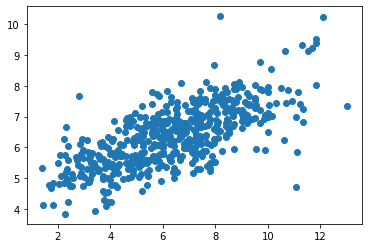

In [44]:
plt.scatter(y_test, predicted_crystal)
print(stats.pearsonr(y_test, predicted_crystal)[0])

0.6589021380413864


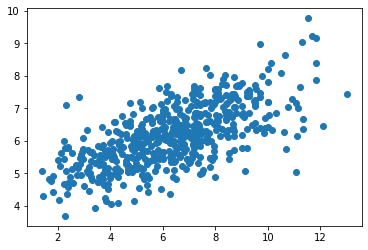

In [45]:
plt.scatter(y_test, predicted_docked)
print(stats.pearsonr(y_test, predicted_docked)[0])

In [47]:
%%time

# using original plecscore params
plecscore_crystal = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=8, oob_score=True)
plecscore_crystal.fit(X_train_crystal, y_train)
plecscore_docked = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=8, oob_score=True)
plecscore_docked.fit(X_train_docked, y_train)

CPU times: user 42min 54s, sys: 3 s, total: 42min 57s
Wall time: 5min 52s


RandomForestRegressor(n_jobs=8, oob_score=True, random_state=0)

In [48]:
predicted_plecscore_crystal = plecscore_crystal.predict(X_test_crystal)
predicted_plecscore_docked = plecscore_docked.predict(X_test_docked)

0.6855406644517302


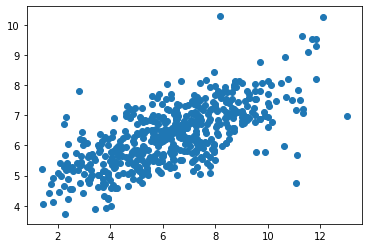

In [49]:
plt.scatter(y_test, predicted_plecscore_crystal)
print(stats.pearsonr(y_test, predicted_plecscore_crystal)[0])

0.6449895681766727


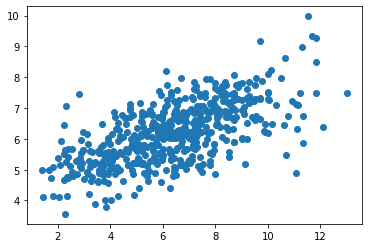

In [50]:
plt.scatter(y_test, predicted_plecscore_docked)
print(stats.pearsonr(y_test, predicted_plecscore_docked)[0])

In [6]:
del train_features_docked
del test_features_docked
del train_features_dense_docked
del test_features_dense_docked

NameError: name 'train_features_dense_docked' is not defined

In [6]:
pdbbind_training_set = pd.Index(train_pdbs)
pdbbind_test_set = pd.Index(test_pdbs)

In [7]:
blast_clusters = {}
for cutoff in [30, 40, 50, 70, 90, 95, 100]:
    with open(f'../data/bc-{cutoff}.out') as f:
        blast_clusters[cutoff] = [set(item[:4].lower() for item in line.strip().split()) for line in f]

test_set_similar_pdbs = {}
for cutoff in blast_clusters:
    pdbs = set()
    for pdb in pdbbind_test_set:
        for cluster in blast_clusters[cutoff]:
            if pdb in cluster:
                pdbs.update(cluster)
    test_set_similar_pdbs[cutoff] = pd.Index(pdbs).intersection(pdbbind_training_set)

test_set_similar_pdbs['All'] = pd.Index([])

In [8]:
with open('../data/pdbbind_ligand_tanimoto_similarity.json') as f:
    tanimoto_similarity = json.load(f)

tc_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

test_set_similar_ligands = {}

for t in tc_thresholds:
    similar = set()
    for pdb_test in pdbbind_test_set:
        for pdb_train in pdbbind_training_set:
            if pdb_train in similar:
                continue
            if tanimoto_similarity[pdb_test][pdb_train] >= t:
                similar.add(pdb_train)
    test_set_similar_ligands[t] = pd.Index(similar)
test_set_similar_ligands['All'] = pd.Index([])

In [13]:
y_train = []
X_train_crystal = []
X_train_docked = []
labels = []
for plec_docked, plec_crystal, pdb in zip(train_features_crystal, train_features_docked, train_pdbs):
    X_train_crystal.append(sparse_to_csr_matrix(plec_crystal, size=65536))
    X_train_docked.append(sparse_to_csr_matrix(plec_docked, size=65536))
    y_train.append(train_affinity.loc[pdb])
X_train_crystal = sparse.vstack(X_train_crystal, format='csr')
X_train_docked = sparse.vstack(X_train_docked, format='csr')

In [14]:
y_test = []
X_test_crystal = []
X_test_docked = []
labels = []
for pdb in test_pdbs:
    X_test_crystal.append(sparse_to_csr_matrix(test_features_crystal[pdb], size=65536))
    X_test_docked.append(sparse_to_csr_matrix(test_features_docked[pdb], size=65536))
    y_test.append(test_affinity.loc[pdb])
X_test_crystal = sparse.vstack(X_test_crystal, format='csr')
X_test_docked = sparse.vstack(X_test_docked, format='csr')

In [17]:
%%time
predicted_crystal_sequence_identity = {}
predicted_docked_sequence_identity = {}
pearsonr_crystal_sequence_identity = {}
pearsonr_docked_sequence_identity = {}

X_test_crystal = []
X_test_docked = []
y_test = []
for pdb in pdbbind_test_set:
    X_test_crystal.append(sparse_to_csr_matrix(test_features_crystal[pdb], size=65536))
    X_test_docked.append(sparse_to_csr_matrix(test_features_docked[pdb], size=65536))
    y_test.append(test_affinity.loc[pdb])
X_test_crystal = sparse.vstack(X_test_crystal, format='csr')
X_test_docked = sparse.vstack(X_test_docked, format='csr')

for cutoff in test_set_similar_pdbs:
    print(cutoff)
    y_train = []
    X_train_crystal = []
    X_train_docked = []
    for plec_docked, plec_crystal, pdb in zip(train_features_crystal, train_features_docked, pdbbind_training_set):
        if pdb in test_set_similar_pdbs[cutoff]:
            continue
        X_train_crystal.append(sparse_to_csr_matrix(plec_crystal, size=65536))
        X_train_docked.append(sparse_to_csr_matrix(plec_docked, size=65536))
        y_train.append(train_affinity.loc[pdb])
    X_train_crystal = sparse.vstack(X_train_crystal, format='csr')
    X_train_docked = sparse.vstack(X_train_docked, format='csr')
    
    rf_crystal = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_crystal.fit(X_train_crystal, y_train)
    rf_docked = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_docked.fit(X_train_docked, y_train)
    
    predicted_crystal = rf_crystal.predict(X_test_crystal)
    predicted_docked = rf_docked.predict(X_test_docked)
    predicted_crystal_sequence_identity[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_crystal)}
    predicted_docked_sequence_identity[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_docked)}
    
    pearsonr_crystal_sequence_identity[cutoff] = stats.pearsonr(y_test, predicted_crystal)[0]
    pearsonr_docked_sequence_identity[cutoff] = stats.pearsonr(y_test, predicted_docked)[0]

30
40
50
70
90
95
100
All
CPU times: user 7h 17min 48s, sys: 19.3 s, total: 7h 18min 8s
Wall time: 59min 9s


In [22]:
%%time
predicted_crystal_tanimoto = {}
predicted_docked_tanimoto = {}
pearsonr_crystal_tanimoto = {}
pearsonr_docked_tanimoto = {}

X_test_crystal = []
X_test_docked = []
y_test = []
for pdb in pdbbind_test_set:
    X_test_crystal.append(sparse_to_csr_matrix(test_features_crystal[pdb], size=65536))
    X_test_docked.append(sparse_to_csr_matrix(test_features_docked[pdb], size=65536))
    y_test.append(test_affinity.loc[pdb])
X_test_crystal = sparse.vstack(X_test_crystal, format='csr')
X_test_docked = sparse.vstack(X_test_docked, format='csr')

for cutoff in test_set_similar_ligands:
    print(cutoff)
    y_train = []
    X_train_crystal = []
    X_train_docked = []
    for plec_docked, plec_crystal, pdb in zip(train_features_crystal, train_features_docked, pdbbind_training_set):
        if pdb in test_set_similar_ligands[cutoff]:
            continue
        X_train_crystal.append(sparse_to_csr_matrix(plec_crystal, size=65536))
        X_train_docked.append(sparse_to_csr_matrix(plec_docked, size=65536))
        y_train.append(train_affinity.loc[pdb])
    X_train_crystal = sparse.vstack(X_train_crystal, format='csr')
    X_train_docked = sparse.vstack(X_train_docked, format='csr')
    
    rf_crystal = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_crystal.fit(X_train_crystal, y_train)
    rf_docked = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_docked.fit(X_train_docked, y_train)
    
    predicted_crystal = rf_crystal.predict(X_test_crystal)
    predicted_docked = rf_docked.predict(X_test_docked)
    predicted_crystal_tanimoto[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_crystal)}
    predicted_docked_tanimoto[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_docked)}
    
    pearsonr_crystal_tanimoto[cutoff] = stats.pearsonr(y_test, predicted_crystal)[0]
    pearsonr_docked_tanimoto[cutoff] = stats.pearsonr(y_test, predicted_docked)[0]

0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
All
CPU times: user 13h 22min 35s, sys: 2min 36s, total: 13h 25min 12s
Wall time: 1h 59min 37s


In [32]:
with open('PLEC_predicted_crystal_sequence_identity.json', 'w') as f:
    json.dump(predicted_crystal_sequence_identity, f, cls=NumpyEncoder)
with open('PLEC_predicted_docked_sequence_identity.json', 'w') as f:
    json.dump(predicted_docked_sequence_identity, f, cls=NumpyEncoder)
with open('PLEC_pearsonr_crystal_sequence_identity.json', 'w') as f:
    json.dump(pearsonr_crystal_sequence_identity, f, cls=NumpyEncoder)
with open('PLEC_pearsonr_docked_sequence_identity.json', 'w') as f:
    json.dump(pearsonr_docked_sequence_identity, f, cls=NumpyEncoder)

In [23]:
with open('PLEC_predicted_crystal_tanimoto.json', 'w') as f:
    json.dump(predicted_crystal_tanimoto, f, cls=NumpyEncoder)
with open('PLEC_predicted_docked_tanimoto.json', 'w') as f:
    json.dump(predicted_docked_tanimoto, f, cls=NumpyEncoder)
with open('PLEC_pearsonr_crystal_tanimoto.json', 'w') as f:
    json.dump(pearsonr_crystal_tanimoto, f, cls=NumpyEncoder)
with open('PLEC_pearsonr_docked_tanimoto.json', 'w') as f:
    json.dump(pearsonr_docked_tanimoto, f, cls=NumpyEncoder)

In [21]:
with open('PLEC_predicted_crystal_sequence_identity.json') as f:
    predicted_crystal_sequence_identity = json.load(f)
with open('PLEC_predicted_docked_sequence_identity.json') as f:
    predicted_docked_sequence_identity = json.load(f)
with open('PLEC_pearsonr_crystal_sequence_identity.json') as f:
    pearsonr_crystal_sequence_identity = json.load(f)
with open('PLEC_pearsonr_docked_sequence_identity.json') as f:
    pearsonr_docked_sequence_identity = json.load(f)

In [30]:
with open('PLEC_predicted_crystal_tanimoto.json') as f:
    predicted_crystal_tanimoto = json.load(f)
with open('PLEC_predicted_docked_tanimoto.json') as f:
    predicted_docked_tanimoto = json.load(f)
with open('PLEC_pearsonr_crystal_tanimoto.json') as f:
    pearsonr_crystal_tanimoto = json.load(f)
with open('PLEC_pearsonr_docked_tanimoto.json') as f:
    pearsonr_docked_tanimoto = json.load(f)

In [41]:
import statistical_tests as st

pearsonr_ci_crystal_si = {}
pearsonr_ci_docked_si = {}
pearsonr_pval_crystal_si = {}
pearsonr_pval_docked_si = {}
pearsonr_ci_crystal_tc = {}
pearsonr_ci_docked_tc = {}
pearsonr_pval_crystal_tc = {}
pearsonr_pval_docked_tc = {}

y_test = test_affinity.loc[pdbbind_test_set]
for cutoff in predicted_crystal_sequence_identity:
    y_pred = pd.Series(predicted_crystal_sequence_identity[cutoff]).loc[pdbbind_test_set]
    pearsonr_ci_crystal_si[cutoff] = st.bootstrap_pearsonr(y_test, y_pred)
    pearsonr_pval_crystal_si[cutoff] = st.permutation_pearsonr(y_test, y_pred)
    y_pred = pd.Series(predicted_docked_sequence_identity[cutoff]).loc[pdbbind_test_set]
    pearsonr_pval_docked_si[cutoff] = st.permutation_pearsonr(y_test, y_pred)
    pearsonr_ci_docked_si[cutoff] = st.bootstrap_pearsonr(y_test, y_pred)

for cutoff in predicted_crystal_tanimoto:
    y_pred = pd.Series(predicted_crystal_tanimoto[cutoff]).loc[pdbbind_test_set]
    pearsonr_ci_crystal_tc[cutoff] = st.bootstrap_pearsonr(y_test, y_pred)
    pearsonr_pval_crystal_tc[cutoff] = st.permutation_pearsonr(y_test, y_pred)
    y_pred = pd.Series(predicted_docked_tanimoto[cutoff]).loc[pdbbind_test_set]
    pearsonr_ci_docked_tc[cutoff] = st.bootstrap_pearsonr(y_test, y_pred)
    pearsonr_pval_docked_tc[cutoff] = st.permutation_pearsonr(y_test, y_pred)

In [42]:
pearsonr_ci_crystal_si

{'30': (0.5608741009330555, 0.5034597530881951, 0.6132666208573603),
 '40': (0.5913791650624448, 0.5341760764513837, 0.6445723559667932),
 '50': (0.6234230604628606, 0.5717141127418369, 0.6719038999799519),
 '70': (0.6305215293531099, 0.5788854945214194, 0.6784414090677245),
 '90': (0.6312312482487037, 0.5785414080015201, 0.6792700493918344),
 '95': (0.6269577836939475, 0.5724170234559904, 0.6760374415105496),
 '100': (0.6368134529910341, 0.5842940963707411, 0.6846061047681368),
 'All': (0.7036850723759726, 0.6509589693948276, 0.750363682672983)}

In [43]:
pearsonr_ci_docked_si

{'30': (0.5155715433596537, 0.4535281039908289, 0.5738242056385738),
 '40': (0.5605298847168476, 0.5034639839156777, 0.6153553132277119),
 '50': (0.5788050126125085, 0.5199707667458673, 0.6337116034631743),
 '70': (0.5812555780764976, 0.522806582566388, 0.6359812500621136),
 '90': (0.5846511912601939, 0.5251838776365342, 0.640403568227971),
 '95': (0.5901686056903788, 0.5325995610239426, 0.6442509056380263),
 '100': (0.5877530928105802, 0.5296199137159089, 0.6416096794491223),
 'All': (0.6589021380413865, 0.6044658300748218, 0.707974543291743)}

In [44]:
pearsonr_ci_crystal_tc

{'0.3': (0.5318314550480853, 0.4677825464305126, 0.5917563735269862),
 '0.4': (0.5970674284521498, 0.5402787589514177, 0.6500329153571455),
 '0.5': (0.637950143307531, 0.5862460677406799, 0.685378913786856),
 '0.6': (0.6448400730681342, 0.5903191915353548, 0.6935316084565047),
 '0.7': (0.6621781101499636, 0.6060900610839468, 0.711851947462418),
 '0.8': (0.6754903204199456, 0.6203825366947284, 0.7247551277966111),
 '0.9': (0.6751710730780369, 0.6184976276845267, 0.7246959647192494),
 '1.0': (0.6775712002367988, 0.6217219802692991, 0.7264881819482855),
 'All': (0.7036850723759727, 0.6509589693948276, 0.7503636826729831)}

In [45]:
pearsonr_ci_docked_tc

{'0.3': (0.5024189574415638, 0.4380963519214656, 0.5628014577870434),
 '0.4': (0.5728692269438753, 0.5183933229031855, 0.6231338182230675),
 '0.5': (0.6098750495529451, 0.5533631943550461, 0.6611656620277508),
 '0.6': (0.6182024005551553, 0.5622290193601678, 0.6687593149710858),
 '0.7': (0.6467688886755133, 0.5896229636545363, 0.6970139511255014),
 '0.8': (0.6410935126691529, 0.5829180331014653, 0.6929543393122994),
 '0.9': (0.6469053311847747, 0.5907694138536167, 0.6979040985559047),
 '1.0': (0.644630642276492, 0.5884667170086832, 0.6953131736230113),
 'All': (0.6589021380413864, 0.6044658300748218, 0.7079745432917431)}

In [14]:
lb_features = pd.read_csv('lb_features.csv', index_col=0)

In [17]:
pd.Series(predicted_docked_sequence_identity['All'])

4pcs    6.00974
1sl3    8.38248
3kwa    5.43680
3bv9    6.66958
3ueu    5.69118
         ...   
4ivb    7.97460
2wn9    5.62578
1rnt    4.96144
2jdm    5.30218
4gr0    7.60306
Length: 519, dtype: float64

In [18]:
@delayed
def get_plec(protein, ligand):
    features = PLEC(ligand, protein, depth_ligand=1, depth_protein=5, size=65536, count_bits=True, sparse=True, ignore_hoh=True)
    return features

In [20]:
targets = ['AKT1', 'CP3A4', 'GCR', 'HIVPR', 'HIVRT', 'KIF11']
chembl_plecs = {}
for target in targets:
    protein = next(ob.readfile('pdb', f'../dude_chembl/dude_data/{target.lower()}/receptor.pdb'))
    protein.protein = True
    ligands = {}
    ligand_file = f'../dude_chembl/{target}_docked.sdf'
    for mol in ob.readfile('sdf', ligand_file):
        mol_name = mol.OBMol.GetTitle()
        if mol_name in ligands:
            continue
        ligands[mol_name] = mol
    with Parallel(n_jobs=8, verbose=10) as parallel:
        results = parallel(get_plec(protein, ligands[mol_name]) for mol_name in ligands)
    chembl_plecs[target] = {mol_name: result for mol_name, result in zip(ligands, results)}

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    7.5s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:   10.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   12.6s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:   15.0s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:   17.2s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:   19.8s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:   22.3s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:   25.4s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:   28.5s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:   31.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   34.9s
[Parallel(

In [23]:
chembl_plecs['KIF11'][mol_name]

array([   37,    92,   120, ..., 65388, 65388, 65388], dtype=uint32)

In [24]:
with open('../data/dude_chembl_plec_finterprints.json', 'w') as f:
    json.dump(chembl_plecs, f, cls=NumpyEncoder)

In [ ]:
X_train_sparse = sparse.vstack([sparse_to_csr_matrix(plec, size=65536) for plec in train_features_crystal], format='csr')
X_test_sparse = sparse.vstack([sparse_to_csr_matrix(test_features_crystal[pdb], size=65536) for pdb in test_features_crystal], format='csr')

svd = TruncatedSVD(n_components=200, random_state=42).fit(X_train_sparse)
X_train_svd = svd.transform(X_train_sparse)
X_test_svd = svd.transform(X_test_sparse)

In [10]:
crystal_pose_features = pd.read_csv('../data/crystal_pose_features.csv', index_col=0)
feature_sets = {}
with open('../data/lb_feature_names.txt') as f:
    feature_sets['LB'] = pd.Index([l.strip() for l in f])
lb_features = pd.read_csv('../data/crystal_pose_features.csv', index_col=0).loc[:, feature_sets['LB']]

In [13]:
pdbbind_training_set_pk = pd.read_csv('../data/pdbbind_training_set_binding_affinity.csv', index_col=0, header=None, squeeze=True)
pdbbind_test_set_pk = pd.read_csv('../data/pdbbind_test_set_binding_affinity.csv', index_col=0, header=None, squeeze=True)

In [18]:
#%%time
predicted_svd_crystal_sequence_identity = {}
predicted_svd_docked_sequence_identity = {}
pearsonr_svd_crystal_sequence_identity = {}
pearsonr_svd_docked_sequence_identity = {}

predicted_svd_rdk_crystal_sequence_identity = {}
predicted_svd_rdk_docked_sequence_identity = {}
pearsonr_svd_rdk_crystal_sequence_identity = {}
pearsonr_svd_rdk_docked_sequence_identity = {}

y_test = []
for pdb in pdbbind_test_set:
    y_test.append(pdbbind_test_set_pk.loc[pdb])

for cutoff in test_set_similar_pdbs:
    print(cutoff)
    y_train = []
    X_train_crystal = []
    X_train_docked = []
    for plec_docked, plec_crystal, pdb in zip(train_features_crystal, train_features_docked, pdbbind_training_set):
        if pdb in test_set_similar_pdbs[cutoff]:
            continue
        X_train_crystal.append(sparse_to_csr_matrix(plec_crystal, size=65536))
        X_train_docked.append(sparse_to_csr_matrix(plec_docked, size=65536))
        y_train.append(pdbbind_training_set_pk.loc[pdb])
    X_train_crystal = sparse.vstack(X_train_crystal, format='csr')
    X_train_docked = sparse.vstack(X_train_docked, format='csr')
    
    # need to rebuild test set each time as svd will be different
    X_test_crystal = []
    X_test_docked = []
    for pdb in pdbbind_test_set:
        X_test_crystal.append(sparse_to_csr_matrix(test_features_crystal[pdb], size=65536))
        X_test_docked.append(sparse_to_csr_matrix(test_features_docked[pdb], size=65536))
    X_test_crystal = sparse.vstack(X_test_crystal, format='csr')
    X_test_docked = sparse.vstack(X_test_docked, format='csr')

    training_set = pdbbind_training_set.difference(test_set_similar_pdbs[cutoff])
    rdk_train = lb_features.loc[training_set].values
    rdk_test = lb_features.loc[pdbbind_test_set].values
    
    svd = TruncatedSVD(n_components=200, random_state=42).fit(X_train_crystal)
    X_train_crystal = svd.transform(X_train_crystal)
    X_test_crystal = svd.transform(X_test_crystal)
    
    svd = TruncatedSVD(n_components=200, random_state=42).fit(X_train_docked)
    X_train_docked = svd.transform(X_train_docked)
    X_test_docked = svd.transform(X_test_docked)
    
    rf_crystal = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_crystal.fit(X_train_crystal, y_train)
    rf_docked = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_docked.fit(X_train_docked, y_train)
    
    predicted_svd_crystal = rf_crystal.predict(X_test_crystal)
    predicted_svd_docked = rf_docked.predict(X_test_docked)
    predicted_svd_crystal_sequence_identity[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_svd_crystal)}
    predicted_svd_docked_sequence_identity[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_svd_docked)}
    
    pearsonr_svd_crystal_sequence_identity[cutoff] = bootstrap_pearsonr(np.array(y_test), predicted_svd_crystal)
    pearsonr_svd_docked_sequence_identity[cutoff] = bootstrap_pearsonr(np.array(y_test), predicted_svd_docked)
    
    # add rdk features
    
    X_train_crystal = np.concatenate((X_train_crystal, rdk_train), axis=1)
    X_test_crystal = np.concatenate((X_test_crystal, rdk_test), axis=1)
    X_train_docked = np.concatenate((X_train_docked, rdk_train), axis=1)
    X_test_docked = np.concatenate((X_test_docked, rdk_test), axis=1)

    rf_crystal = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_crystal.fit(X_train_crystal, y_train)
    rf_docked = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_docked.fit(X_train_docked, y_train)
    
    predicted_svd_rdk_crystal = rf_crystal.predict(X_test_crystal)
    predicted_svd_rdk_docked = rf_docked.predict(X_test_docked)
    predicted_svd_rdk_crystal_sequence_identity[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_svd_rdk_crystal)}
    predicted_svd_rdk_docked_sequence_identity[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_svd_rdk_docked)}
    
    pearsonr_svd_rdk_crystal_sequence_identity[cutoff] = bootstrap_pearsonr(np.array(y_test), predicted_svd_rdk_crystal)
    pearsonr_svd_rdk_docked_sequence_identity[cutoff] = bootstrap_pearsonr(np.array(y_test), predicted_svd_rdk_docked)

30
40
50
70
90
95
100
All


In [20]:
#%%time
predicted_svd_crystal_tanimoto = {}
predicted_svd_docked_tanimoto = {}
pearsonr_svd_crystal_tanimoto = {}
pearsonr_svd_docked_tanimoto = {}

predicted_svd_rdk_crystal_tanimoto = {}
predicted_svd_rdk_docked_tanimoto = {}
pearsonr_svd_rdk_crystal_tanimoto = {}
pearsonr_svd_rdk_docked_tanimoto = {}

y_test = []
for pdb in pdbbind_test_set:
    y_test.append(pdbbind_test_set_pk.loc[pdb])

for cutoff in test_set_similar_ligands:
    print(cutoff)
    y_train = []
    X_train_crystal = []
    X_train_docked = []
    for plec_docked, plec_crystal, pdb in zip(train_features_crystal, train_features_docked, pdbbind_training_set):
        if pdb in test_set_similar_ligands[cutoff]:
            continue
        X_train_crystal.append(sparse_to_csr_matrix(plec_crystal, size=65536))
        X_train_docked.append(sparse_to_csr_matrix(plec_docked, size=65536))
        y_train.append(pdbbind_training_set_pk.loc[pdb])
    X_train_crystal = sparse.vstack(X_train_crystal, format='csr')
    X_train_docked = sparse.vstack(X_train_docked, format='csr')
    
    # need to rebuild test set each time as svd will be different
    X_test_crystal = []
    X_test_docked = []
    for pdb in pdbbind_test_set:
        X_test_crystal.append(sparse_to_csr_matrix(test_features_crystal[pdb], size=65536))
        X_test_docked.append(sparse_to_csr_matrix(test_features_docked[pdb], size=65536))
    X_test_crystal = sparse.vstack(X_test_crystal, format='csr')
    X_test_docked = sparse.vstack(X_test_docked, format='csr')

    training_set = pdbbind_training_set.difference(test_set_similar_ligands[cutoff])
    rdk_train = lb_features.loc[training_set].values
    rdk_test = lb_features.loc[pdbbind_test_set].values
    
    svd = TruncatedSVD(n_components=200, random_state=42).fit(X_train_crystal)
    X_train_crystal = svd.transform(X_train_crystal)
    X_test_crystal = svd.transform(X_test_crystal)
    
    svd = TruncatedSVD(n_components=200, random_state=42).fit(X_train_docked)
    X_train_docked = svd.transform(X_train_docked)
    X_test_docked = svd.transform(X_test_docked)
    
    rf_crystal = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_crystal.fit(X_train_crystal, y_train)
    rf_docked = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_docked.fit(X_train_docked, y_train)
    
    predicted_svd_crystal = rf_crystal.predict(X_test_crystal)
    predicted_svd_docked = rf_docked.predict(X_test_docked)
    predicted_svd_crystal_tanimoto[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_svd_crystal)}
    predicted_svd_docked_tanimoto[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_svd_docked)}
    
    pearsonr_svd_crystal_tanimoto[cutoff] = bootstrap_pearsonr(np.array(y_test), predicted_svd_crystal)
    pearsonr_svd_docked_tanimoto[cutoff] = bootstrap_pearsonr(np.array(y_test), predicted_svd_docked)
    
    # add rdk features
    
    X_train_crystal = np.concatenate((X_train_crystal, rdk_train), axis=1)
    X_test_crystal = np.concatenate((X_test_crystal, rdk_test), axis=1)
    X_train_docked = np.concatenate((X_train_docked, rdk_train), axis=1)
    X_test_docked = np.concatenate((X_test_docked, rdk_test), axis=1)

    rf_crystal = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_crystal.fit(X_train_crystal, y_train)
    rf_docked = RandomForestRegressor(n_estimators=500, max_features=0.33,random_state=42, n_jobs=8, oob_score=True)
    rf_docked.fit(X_train_docked, y_train)
    
    predicted_svd_rdk_crystal = rf_crystal.predict(X_test_crystal)
    predicted_svd_rdk_docked = rf_docked.predict(X_test_docked)
    predicted_svd_rdk_crystal_tanimoto[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_svd_rdk_crystal)}
    predicted_svd_rdk_docked_tanimoto[cutoff] = {pdb: pred for pdb, pred in zip(pdbbind_test_set, predicted_svd_rdk_docked)}
    
    pearsonr_svd_rdk_crystal_tanimoto[cutoff] = bootstrap_pearsonr(np.array(y_test), predicted_svd_rdk_crystal)
    pearsonr_svd_rdk_docked_tanimoto[cutoff] = bootstrap_pearsonr(np.array(y_test), predicted_svd_rdk_docked)

0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
All


In [25]:
pearsonr_ci_crystal_si

{'30': (0.5608741009330555, 0.5034597530881951, 0.6132666208573603),
 '40': (0.5913791650624448, 0.5341760764513837, 0.6445723559667932),
 '50': (0.6234230604628606, 0.5717141127418369, 0.6719038999799519),
 '70': (0.6305215293531099, 0.5788854945214194, 0.6784414090677245),
 '90': (0.6312312482487037, 0.5785414080015201, 0.6792700493918344),
 '95': (0.6269577836939475, 0.5724170234559904, 0.6760374415105496),
 '100': (0.6368134529910341, 0.5842940963707411, 0.6846061047681368),
 'All': (0.7036850723759726, 0.6509589693948276, 0.750363682672983)}

In [48]:
for cutoff in pearsonr_ci_crystal_si:
    c = pearsonr_ci_crystal_si[cutoff]
    d = pearsonr_ci_docked_si[cutoff]
    print(f'{cutoff} & {c[0]:.3f} ({c[1]:.3f}, {c[2]:.3f}) & {d[0]:.3f} ({d[1]:.3f}, {d[2]:.3f}) \\\\')

30 & 0.561 (0.503, 0.613) & 0.516 (0.454, 0.574) \\
40 & 0.591 (0.534, 0.645) & 0.561 (0.503, 0.615) \\
50 & 0.623 (0.572, 0.672) & 0.579 (0.520, 0.634) \\
70 & 0.631 (0.579, 0.678) & 0.581 (0.523, 0.636) \\
90 & 0.631 (0.579, 0.679) & 0.585 (0.525, 0.640) \\
95 & 0.627 (0.572, 0.676) & 0.590 (0.533, 0.644) \\
100 & 0.637 (0.584, 0.685) & 0.588 (0.530, 0.642) \\
All & 0.704 (0.651, 0.750) & 0.659 (0.604, 0.708) \\


In [49]:
for cutoff in pearsonr_ci_crystal_tc:
    c = pearsonr_ci_crystal_tc[cutoff]
    d = pearsonr_ci_docked_tc[cutoff]
    print(f'{cutoff} & {c[0]:.3f} ({c[1]:.3f}, {c[2]:.3f}) & {d[0]:.3f} ({d[1]:.3f}, {d[2]:.3f}) \\\\')

0.3 & 0.532 (0.468, 0.592) & 0.502 (0.438, 0.563) \\
0.4 & 0.597 (0.540, 0.650) & 0.573 (0.518, 0.623) \\
0.5 & 0.638 (0.586, 0.685) & 0.610 (0.553, 0.661) \\
0.6 & 0.645 (0.590, 0.694) & 0.618 (0.562, 0.669) \\
0.7 & 0.662 (0.606, 0.712) & 0.647 (0.590, 0.697) \\
0.8 & 0.675 (0.620, 0.725) & 0.641 (0.583, 0.693) \\
0.9 & 0.675 (0.618, 0.725) & 0.647 (0.591, 0.698) \\
1.0 & 0.678 (0.622, 0.726) & 0.645 (0.588, 0.695) \\
All & 0.704 (0.651, 0.750) & 0.659 (0.604, 0.708) \\


In [50]:
for cutoff in pearsonr_svd_crystal_sequence_identity:
    c = pearsonr_svd_crystal_sequence_identity[cutoff]
    d = pearsonr_svd_docked_sequence_identity[cutoff]
    cr = pearsonr_svd_rdk_crystal_sequence_identity[cutoff]
    dr = pearsonr_svd_rdk_docked_sequence_identity[cutoff]
    print(f'{cutoff} & {c[0]:.3f} ({c[1]:.3f}, {c[2]:.3f}) & {d[0]:.3f} ({d[1]:.3f}, {d[2]:.3f}) & {cr[0]:.3f} ({cr[1]:.3f}, {cr[2]:.3f}) & {dr[0]:.3f} ({dr[1]:.3f}, {dr[2]:.3f}) \\\\')

30 & 0.552 (0.483, 0.614) & 0.497 (0.429, 0.560) & 0.627 (0.572, 0.676) & 0.625 (0.570, 0.674) \\
40 & 0.625 (0.573, 0.674) & 0.547 (0.487, 0.602) & 0.666 (0.617, 0.711) & 0.649 (0.598, 0.695) \\
50 & 0.655 (0.605, 0.701) & 0.568 (0.506, 0.626) & 0.672 (0.622, 0.716) & 0.659 (0.609, 0.704) \\
70 & 0.657 (0.609, 0.701) & 0.581 (0.520, 0.637) & 0.683 (0.634, 0.727) & 0.675 (0.626, 0.720) \\
90 & 0.656 (0.605, 0.701) & 0.590 (0.528, 0.645) & 0.685 (0.636, 0.728) & 0.680 (0.631, 0.724) \\
95 & 0.657 (0.608, 0.702) & 0.588 (0.529, 0.642) & 0.695 (0.647, 0.737) & 0.683 (0.635, 0.726) \\
100 & 0.653 (0.602, 0.700) & 0.592 (0.532, 0.647) & 0.696 (0.648, 0.739) & 0.682 (0.634, 0.725) \\
All & 0.686 (0.632, 0.732) & 0.635 (0.577, 0.686) & 0.741 (0.696, 0.780) & 0.734 (0.691, 0.772) \\


In [51]:
for cutoff in pearsonr_svd_crystal_tanimoto:
    c = pearsonr_svd_crystal_tanimoto[cutoff]
    d = pearsonr_svd_docked_tanimoto[cutoff]
    cr = pearsonr_svd_rdk_crystal_tanimoto[cutoff]
    dr = pearsonr_svd_rdk_docked_tanimoto[cutoff]
    print(f'{cutoff} & {c[0]:.3f} ({c[1]:.3f}, {c[2]:.3f}) & {d[0]:.3f} ({d[1]:.3f}, {d[2]:.3f}) & {cr[0]:.3f} ({cr[1]:.3f}, {cr[2]:.3f}) & {dr[0]:.3f} ({dr[1]:.3f}, {dr[2]:.3f}) \\\\')

0.3 & 0.542 (0.476, 0.602) & 0.537 (0.474, 0.595) & 0.573 (0.510, 0.630) & 0.576 (0.514, 0.633) \\
0.4 & 0.614 (0.561, 0.663) & 0.561 (0.503, 0.616) & 0.606 (0.546, 0.659) & 0.609 (0.554, 0.661) \\
0.5 & 0.637 (0.587, 0.682) & 0.587 (0.528, 0.642) & 0.652 (0.601, 0.699) & 0.660 (0.611, 0.706) \\
0.6 & 0.648 (0.599, 0.694) & 0.596 (0.541, 0.648) & 0.674 (0.624, 0.720) & 0.683 (0.637, 0.726) \\
0.7 & 0.662 (0.611, 0.707) & 0.604 (0.547, 0.658) & 0.697 (0.648, 0.741) & 0.708 (0.663, 0.749) \\
0.8 & 0.668 (0.617, 0.714) & 0.621 (0.565, 0.672) & 0.707 (0.659, 0.750) & 0.713 (0.667, 0.754) \\
0.9 & 0.668 (0.617, 0.715) & 0.622 (0.565, 0.674) & 0.708 (0.660, 0.751) & 0.716 (0.670, 0.757) \\
1.0 & 0.666 (0.615, 0.712) & 0.621 (0.564, 0.673) & 0.709 (0.661, 0.752) & 0.713 (0.667, 0.755) \\
All & 0.686 (0.632, 0.732) & 0.635 (0.577, 0.686) & 0.741 (0.696, 0.780) & 0.734 (0.691, 0.772) \\
